# Part 2: Convolutional Neural Networks

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

For this assignment you are going to use the dataset IML-2022-Anglo-Saxion-Runes
from Introduction to Machine Learning (see BlackBoard).

There are plenty of examples of how to build convolutional neural networks. We advice
you, however, to reuse the code from your first assignment. 

This time you also need to
use convolutional layers and pooling layers.

In [1]:
import os, re, math, json, shutil, pprint
# import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
from os import listdir
from os.path import isfile, join
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import History
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
print(tf.__version__)

def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axis that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

2.8.2


Loading the data into dataframes

Number of images: 3030


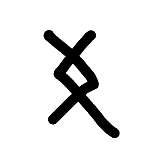

(128, 128, 4)


In [2]:
#change the color to gray picture
from skimage.color import rgb2gray
path = './MLBD-dataset-IML-2022-Anglo-Saxion-Runes'
images_original = io.imread_collection(os.path.join(f'{path}/*.png'))
print(f'Number of images: {len(images_original)}')
display(images_original[0])
print(images_original[0].shape)

Creating a new dataframe with the labels and the image names separated.

In [3]:
dataset_rgba = []
images_as_rgba = []
for file_name in listdir(path):
    full_path = join(path, file_name)
    if isfile(full_path):
        if re.match(r".*\.png$", full_path):
            image_current = io.imread(full_path)
            image_label = file_name.split('_')[0].lower()
            image_number = file_name.split('_')[2].lower() + "_" + file_name.split('_')[3].lower()
            
            image_definition = (image_current, image_number, image_label)
            
            dataset_rgba.append(image_definition)

labeled_images_df = pd.DataFrame(dataset_rgba, columns=["image", "rune_id", "label"])

In [4]:
# labeled_images_df.head(10)

As we can see now, the images are stored as numpy arrays grayscale with 128x128 pixels and contains the rune id and the label as well.

Number of images in dataset 3030
Shape (128, 128, 4)
Numpy Array [[[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 ...

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]]
Rune id 161206_2085017735.png
Label ash


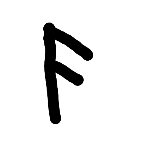

In [5]:
print('Number of images in dataset', len(dataset_rgba))
print('Shape', dataset_rgba[200][0].shape)
print('Numpy Array', dataset_rgba[200][0])
print('Rune id', dataset_rgba[200][1])
print('Label', dataset_rgba[200][2])
display(dataset_rgba[200][0])

In [6]:
print(labeled_images_df['image'].shape)

(3030,)


As it is stated into the the assignment we are going to experiment with different network structures. 

Therefore, we would have to:

- Experiment with at least 6 different network structures with minimum of 2 convolutional layers per network.
- Difference with and without dropout.


In [7]:
BATCH_SIZE = 128
EPOCHS = 10
IMG_SIZE = (128, 128, 4)

In [8]:
# images_original_np_array = np.array(images_original)
# labels_fit_transform = LabelEncoder().fit_transform(labeled_images_df['label'])
# data_set_categorial = tf.keras.utils.to_categorical(labels_fit_transform)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(labeled_images_df, labeled_images_df, test_size=0.2, random_state=123)

In [10]:
print(labeled_images_df.iloc[2]['image'].shape)

(128, 128, 4)


In [11]:
# According to the link below, the keras util requires to have the images in a folder structure 
# so i created the structure with the 11 classes and the images in the corresponding folder
# source: https://stackoverflow.com/a/71704958

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './dataset',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(128, 128),
    batch_size=128
)

Found 3030 files belonging to 11 classes.
Using 2424 files for training.


As the slides are saying, the convolutional layers are used to extract features from the images.
We are going to define a function that will create this for us.

Keras layers engine contains an implementation of the convolutional layer
- Filters = number of filters you want to apply (= number of outputs)
- Kernel size = size of the weights kernel
- Padding = "valid" (don't pad) or "same" (output size equal to input size)
- Strides = stride step size for vertical and horizontal

In [12]:
# def define_conv_layers(model, kernel_size=(3,3), pool_size=(2,2), activation='relu', dropout=0.25):
#     model.add(keras.layers.Conv2D(32, kernel_size, activation=activation,padding='same'))
#     model.add(keras.layers.Activation(activation))
#     model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
#     model.add(keras.layers.Dropout(0.25))

#     model.add(keras.layers.Conv2D(64, kernel_size, padding='same'))
#     model.add(keras.layers.Activation(activation))
#     model.add(keras.layers.Conv2D(64, kernel_size))
#     model.add(keras.layers.Activation(activation))
#     model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
#     model.add(keras.layers.Dropout(0.25))

#     # model.add(keras.layers.Conv2D(128, kernel_size, padding='same'))
#     # model.add(keras.layers.Activation(activation))
#     # model.add(keras.layers.Conv2D(128, kernel_size))
#     # model.add(keras.layers.Activation(activation))
#     # model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
#     # model.add(keras.layers.Dropout(0.25))

#     # model.add(keras.layers.Flatten())
#     # model.add(keras.layers.Dense(512))
#     # model.add(keras.layers.Activation(activation))
#     # model.add(keras.layers.Dropout(0.5))
#     # model.add(keras.layers.Dense(25))
#     # model.add(keras.layers.Activation('softmax'))

#     return model

In [13]:
def plot_acc_loss(history):
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.ylim(1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

• Playing around with different networks sizes (different number of layers, different
number of neurons per layer, at least 6 different networks with a minimum of 2
convolutional layers per network).
• Difference with and without dropout.
• Visualize metrics such as accuracy and cross entropy for both the training set
and validation set (to prove that you are not overfitting the network). Show the
accuracy of your testing set as well.
• Use at least 2 convolutional layers in each network.
• Create a proper output layer using SoftMax activation.
• Convert the labels into one-hot-encoded values.
• Use cross-entropy as loss function for classification.
• Avoid overfitting by using dropout, a test set and cross validation

Experiments

1. 2 conv layers with the basic setup of the network with 32 neurons.
2. 2 conv layers with 64 neurons
3. 2 conv layers with max pooling
4. 2 conv layers adding data augmentation 
5. based on the previous experminet we will increment the neurons number
6. we will do the dropout 


BatchNormalization

Data augmentation and Data segmentation

In [14]:
# Source: https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Experiments

In [15]:
images_original_np_array = np.array(images_original)
labels_fit_transform = LabelEncoder().fit_transform(labeled_images_df['label'])
data_set_categorial = tf.keras.utils.to_categorical(labels_fit_transform)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(images_original_np_array, data_set_categorial, test_size=0.2, random_state=123)

In [16]:
models_and_results = pd.DataFrame()

In [17]:
def create_model(layers=[], kernel_size =(3, 3), learningRate = 0.03, optimizer="adam", 
                    loss_function='categorical_crossentropy', 
                    activation_function="softmax", debug=False):
    model = tf.keras.models.Sequential()
    # Define the input layer 4 channels of RGB
    model.add(tf.keras.layers.Input(shape=IMG_SIZE)) 
    
    # Adding convolutional layers
    for layer in layers:
        model.add(layer)

    # Flatten the output from the convolutional layers
    model.add(tf.keras.layers.Flatten())

    # Define the fully connected layer
    model.add(tf.keras.layers.Dense(512, activation='relu'))

    # Output layer with 11 neurons as we have 11 runes to classify
    # which is using the softmax activation function
    model.add(tf.keras.layers.Dense(11, activation='softmax'))

    if (debug):
        model.summary()

    # if optimizer == "adam":
    #     opti = Adam(learning_rate=learningRate)
    # elif optimizer == "sgd":
    #     opti = SGD(learning_rate=learningRate)
    # elif optimizer == "adagrad":
    #     opti = Adagrad(learning_rate=learningRate)

    # https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
    eas = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')
    
    # history = History()
    # Compile the model
    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'], sample_weight_mode="temporary", callbacks=[eas])
    return model

In [18]:
n_32 = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
]

model = create_model(layers=n_32)
# history = model.fit(X_train_2, y_train_2, epochs=EPOCHS, validation_data=(X_test_2, y_test_2))
# evaluation_results = model.evaluate(X_train_2, y_train_2, batch_size=BATCH_SIZE)
# plot_acc_loss(history)

TypeError: Invalid keyword argument(s) in `compile()`: ({'callbacks'},). Valid keyword arguments include "cloning", "experimental_run_tf_function", "distribute", "target_tensors", or "sample_weight_mode".

In [ ]:
n_64 = [
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
]
model = create_model(layers=n_64)
history = model.fit(X_train_2, y_train_2, epochs=EPOCHS, validation_data=(X_test_2, y_test_2))
plot_acc_loss(history)

: 

: 

Epoch 1/10
76/76 [==============================] - 24s 303ms/step - loss: 53.1094 - accuracy: 0.6192 - val_loss: 0.5207 - val_accuracy: 0.8366
Epoch 2/10
76/76 [==============================] - 22s 283ms/step - loss: 0.3275 - accuracy: 0.8960 - val_loss: 0.4018 - val_accuracy: 0.8795
Epoch 3/10
76/76 [==============================] - 24s 312ms/step - loss: 0.1494 - accuracy: 0.9488 - val_loss: 0.3397 - val_accuracy: 0.9026
Epoch 4/10
76/76 [==============================] - 25s 324ms/step - loss: 0.1179 - accuracy: 0.9649 - val_loss: 0.3139 - val_accuracy: 0.9175
Epoch 5/10
76/76 [==============================] - 22s 286ms/step - loss: 0.0869 - accuracy: 0.9682 - val_loss: 0.4321 - val_accuracy: 0.9010
Epoch 6/10
76/76 [==============================] - 22s 286ms/step - loss: 0.0661 - accuracy: 0.9777 - val_loss: 0.3996 - val_accuracy: 0.9043
Epoch 7/10
76/76 [==============================] - 22s 287ms/step - loss: 0.0427 - accuracy: 0.9868 - val_loss: 0.4260 - val_accuracy: 0.914

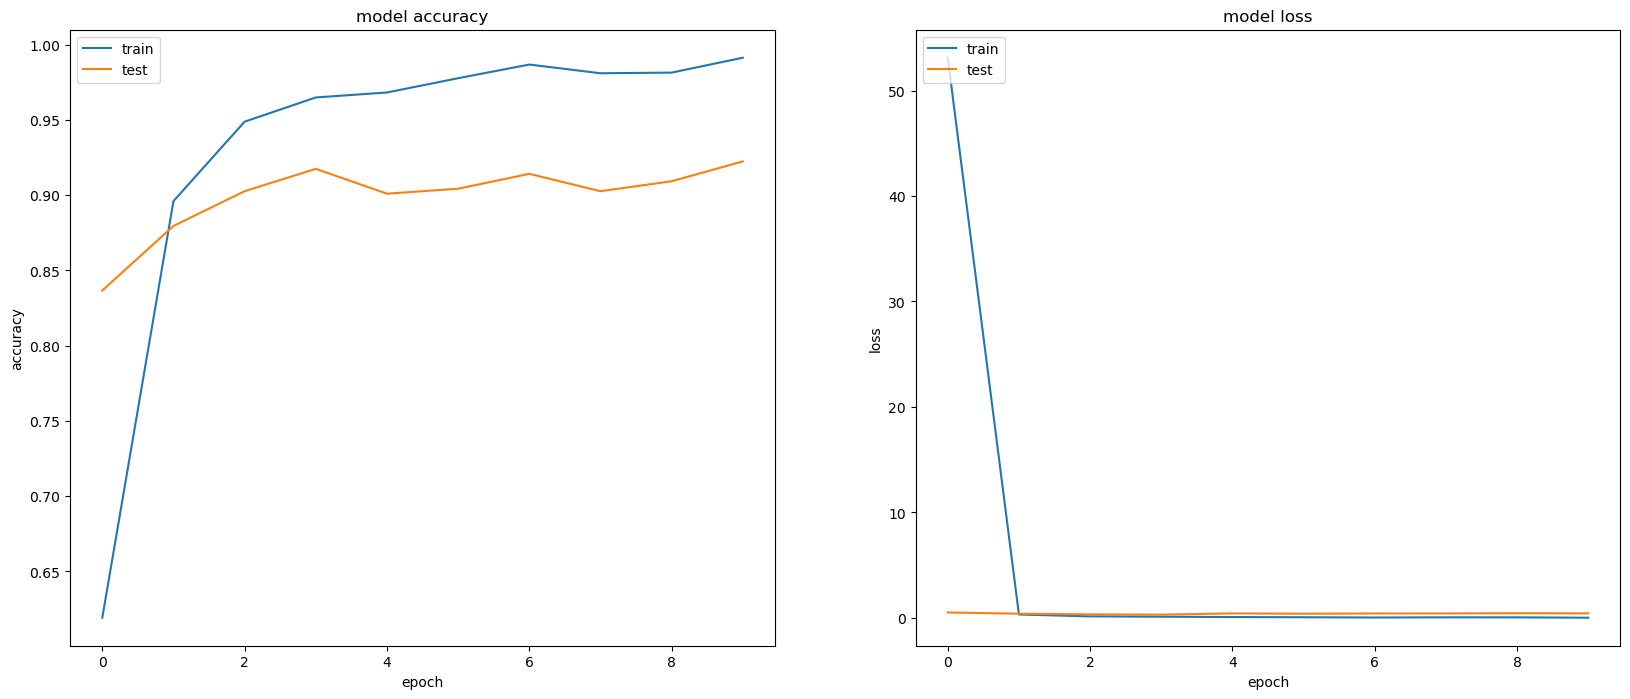

In [ ]:
n_32_64 = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
]
model = create_model(layers=n_32_64)
history = model.fit(X_train_2, y_train_2, epochs=EPOCHS, validation_data=(X_test_2, y_test_2))
plot_acc_loss(history)

Epoch 1/10
76/76 [==============================] - 24s 307ms/step - loss: 40.8706 - accuracy: 0.6304 - val_loss: 0.4898 - val_accuracy: 0.8878
Epoch 2/10
76/76 [==============================] - 21s 277ms/step - loss: 0.3568 - accuracy: 0.9080 - val_loss: 0.3909 - val_accuracy: 0.8812
Epoch 3/10
76/76 [==============================] - 24s 322ms/step - loss: 0.3204 - accuracy: 0.9088 - val_loss: 0.3851 - val_accuracy: 0.8927
Epoch 4/10
76/76 [==============================] - 24s 317ms/step - loss: 0.1411 - accuracy: 0.9554 - val_loss: 0.3726 - val_accuracy: 0.9109
Epoch 5/10
76/76 [==============================] - 23s 298ms/step - loss: 0.0751 - accuracy: 0.9744 - val_loss: 0.3476 - val_accuracy: 0.9175
Epoch 6/10
76/76 [==============================] - 21s 273ms/step - loss: 0.0617 - accuracy: 0.9790 - val_loss: 0.3888 - val_accuracy: 0.9241
Epoch 7/10
76/76 [==============================] - 21s 282ms/step - loss: 0.0321 - accuracy: 0.9922 - val_loss: 0.4559 - val_accuracy: 0.910

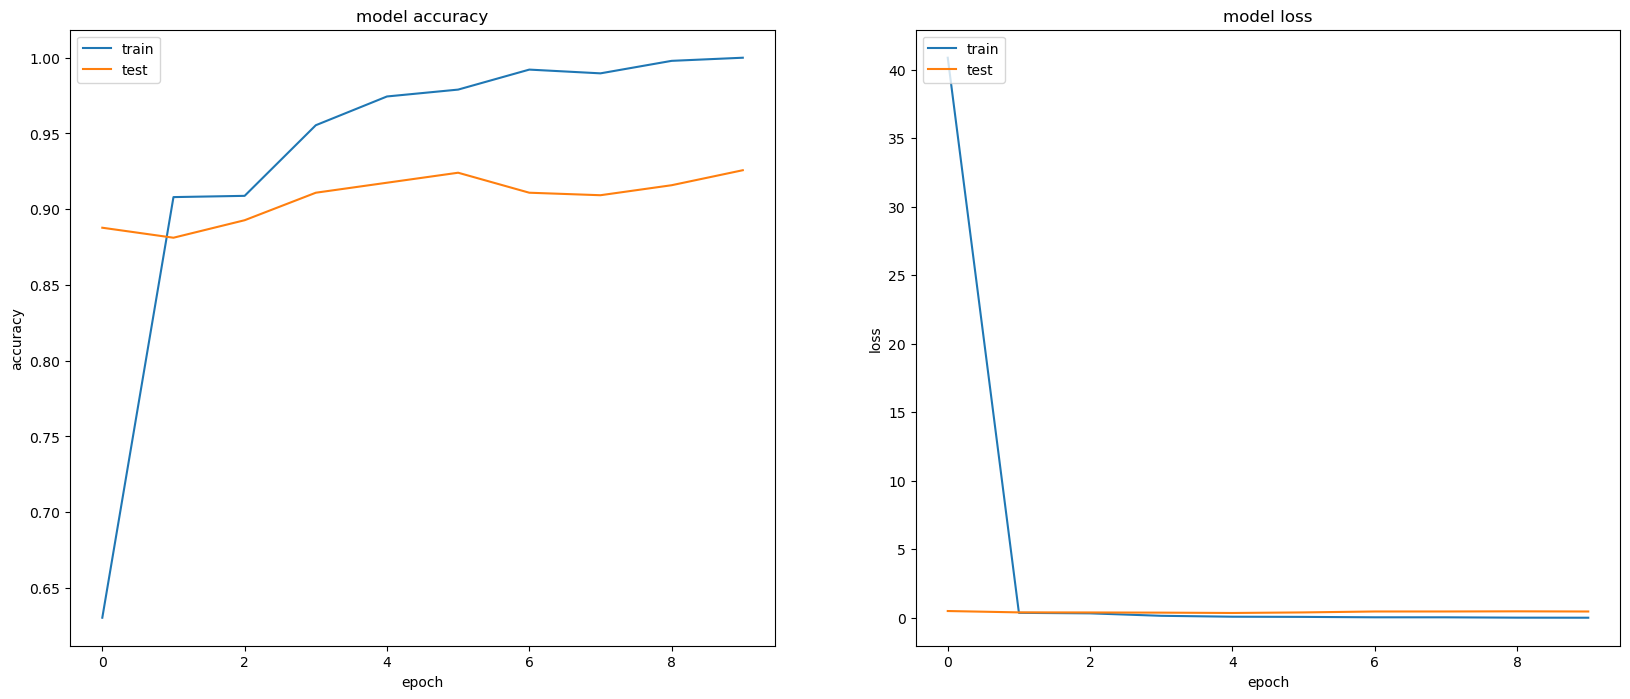

In [ ]:
n_32_64_MP = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
]
model = create_model(layers=n_32_64_MP)
history = model.fit(X_train_2, y_train_2, epochs=EPOCHS, validation_data=(X_test_2, y_test_2))
plot_acc_loss(history)

Epoch 1/10
76/76 [==============================] - 25s 320ms/step - loss: 45.5421 - accuracy: 0.6213 - val_loss: 0.7188 - val_accuracy: 0.7838
Epoch 2/10
76/76 [==============================] - 22s 287ms/step - loss: 0.3841 - accuracy: 0.8841 - val_loss: 0.3726 - val_accuracy: 0.9158
Epoch 3/10
76/76 [==============================] - 23s 303ms/step - loss: 0.2252 - accuracy: 0.9303 - val_loss: 0.3659 - val_accuracy: 0.8812
Epoch 4/10
76/76 [==============================] - 21s 279ms/step - loss: 0.1568 - accuracy: 0.9563 - val_loss: 0.4287 - val_accuracy: 0.8812
Epoch 5/10
76/76 [==============================] - 24s 313ms/step - loss: 0.0951 - accuracy: 0.9658 - val_loss: 0.3907 - val_accuracy: 0.9043
Epoch 6/10
76/76 [==============================] - 22s 283ms/step - loss: 0.0892 - accuracy: 0.9736 - val_loss: 0.4676 - val_accuracy: 0.9191
Epoch 7/10
76/76 [==============================] - 21s 279ms/step - loss: 0.0534 - accuracy: 0.9806 - val_loss: 0.3563 - val_accuracy: 0.899

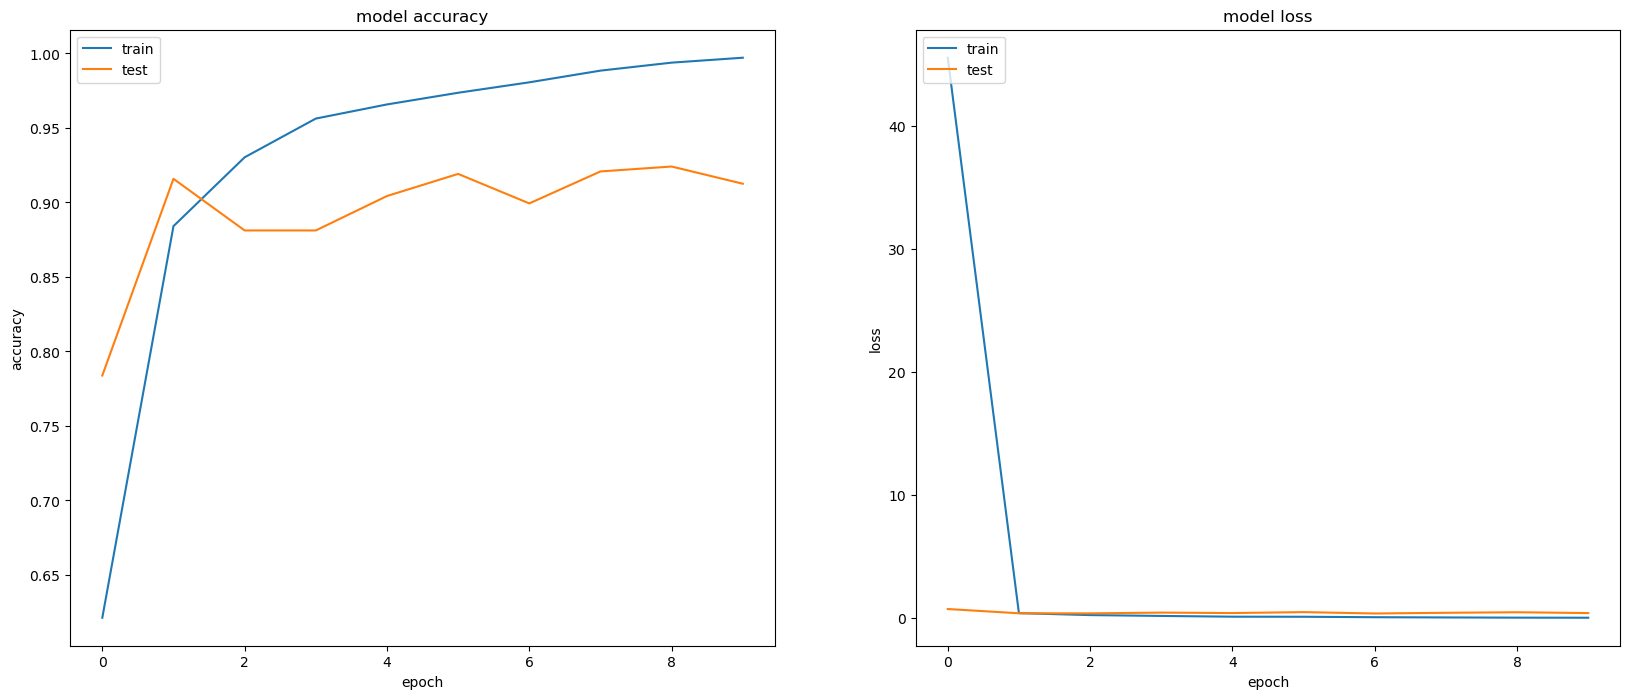

In [ ]:
n_32_64_MP2 = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
]
model = create_model(layers=n_32_64_MP2)
history = model.fit(X_train_2, y_train_2, epochs=EPOCHS, validation_data=(X_test_2, y_test_2))
plot_acc_loss(history)

Epoch 1/10
76/76 [==============================] - 22s 279ms/step - loss: 26.3594 - accuracy: 0.5392 - val_loss: 0.6349 - val_accuracy: 0.8218
Epoch 2/10
76/76 [==============================] - 23s 299ms/step - loss: 0.4116 - accuracy: 0.8676 - val_loss: 0.4090 - val_accuracy: 0.8663
Epoch 3/10
76/76 [==============================] - 21s 273ms/step - loss: 0.2550 - accuracy: 0.9208 - val_loss: 0.4174 - val_accuracy: 0.8696
Epoch 4/10
76/76 [==============================] - 21s 272ms/step - loss: 0.1389 - accuracy: 0.9559 - val_loss: 0.4452 - val_accuracy: 0.8746
Epoch 5/10
76/76 [==============================] - 24s 321ms/step - loss: 0.0835 - accuracy: 0.9707 - val_loss: 0.4020 - val_accuracy: 0.8746
Epoch 6/10
76/76 [==============================] - 30s 394ms/step - loss: 0.0653 - accuracy: 0.9798 - val_loss: 0.4303 - val_accuracy: 0.8762
Epoch 7/10
76/76 [==============================] - 26s 341ms/step - loss: 0.0429 - accuracy: 0.9876 - val_loss: 0.4392 - val_accuracy: 0.881

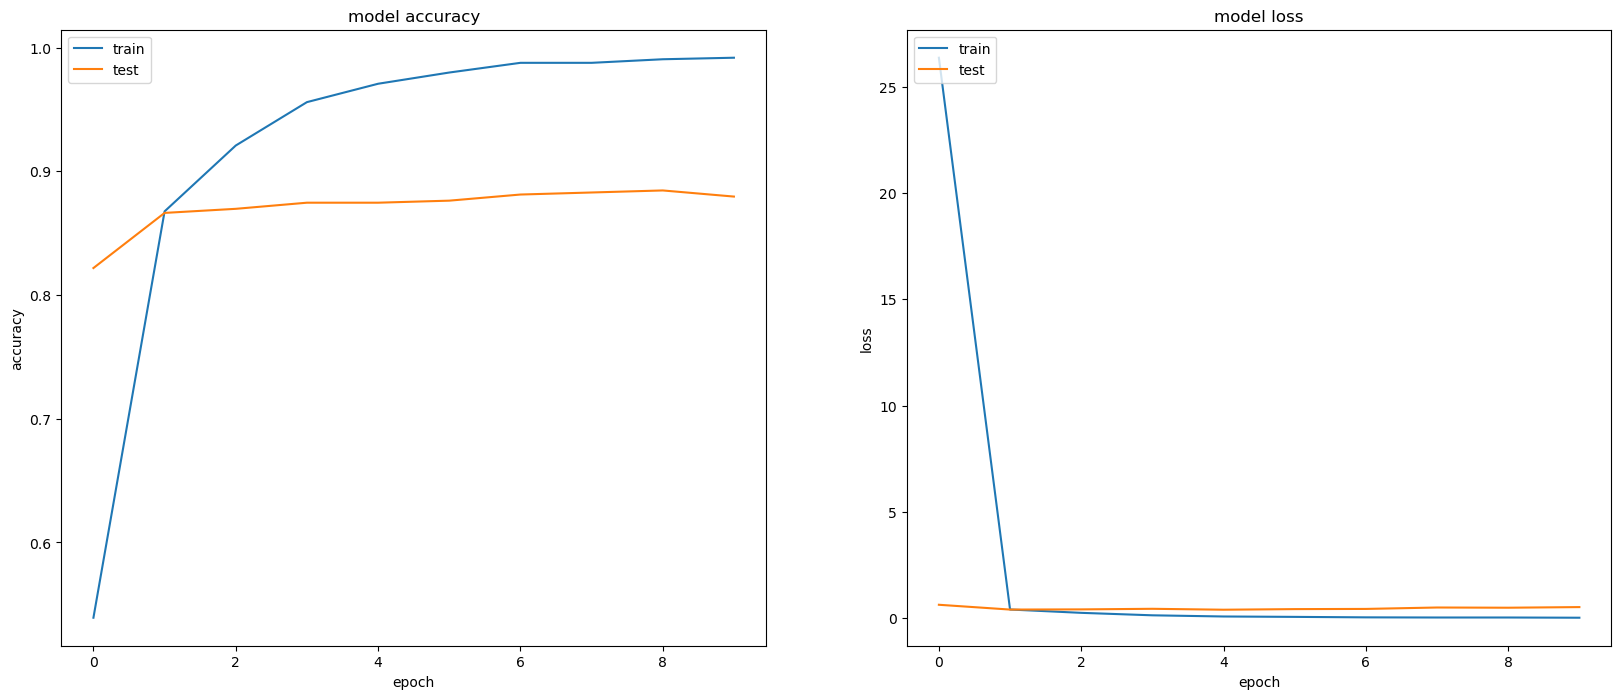

In [ ]:

n_64_MP2 = [
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
]
model = create_model(layers=n_64_MP2)
history = model.fit(X_train_2, y_train_2, epochs=EPOCHS, validation_data=(X_test_2, y_test_2))
plot_acc_loss(history)

In [ ]:
# data augmentation layers
n_DA_64_MP2 = [
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
]